# 사전작업

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import spacy

import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, GRU, Bidirectional, GlobalMaxPooling1D,GlobalAveragePooling1D, Dropout,SpatialDropout1D,Conv1D,concatenate,Flatten
#Bidirectional은 양방향으로 데이터를 보기 위해서 사용되는 함수
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
!python -m spacy download en_core_web_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
nlp = spacy.load('en_core_web_sm')

# loading stop words
stop_words = nlp.Defaults.stop_words
# removing 'not' word from stop words list because this word has enough effect on sentiment
nlp.Defaults.stop_words.remove('not')
nlp.vocab['not'].is_stop = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
cutoff = int(len(data)*0.7)
train_data = data[:cutoff]
test_data = data[cutoff:]

In [ ]:
train_data.shape

(35000, 2)

In [ ]:
test_data.shape

(15000, 2)

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    
    # remove stop words
    raw = []
    for word in text.split():
        if word in stop_words:
            pass
        else:
            raw.append(word)
    text = ' '.join(raw)
    # lemmatization
    text = ' '.join([i.lemma_ for i in nlp(text)])

    return text

In [ ]:
X_train_raw = train_data['review'].map(lambda com : clean_text(com))
X_test_raw = test_data['review'].map(lambda com : clean_text(com))

Y_train = train_data['sentiment']

In [ ]:
print("X train shape : ", X_train_raw.shape)
print("X test shape : ", X_test_raw.shape)
print("y train shape : ", Y_train.shape)

X train shape :  (35000,)
X test shape :  (15000,)
y train shape :  (35000,)


# 토큰화 작업하기

In [ ]:
max_features=90000 #단어 개수 85000개 나왓는뎅 반올림해서 사용
maxlen=90 #단어 개수 중간값 81이 나왔는뎅 올림해서 사용
embed_size=300


tok=Tokenizer(num_words=max_features,lower=True)
tok.fit_on_texts(X_train_raw)
tok.fit_on_texts(X_test_raw)
X_train = sequence.pad_sequences(tok.texts_to_sequences(X_train_raw),
                        maxlen = maxlen, truncating = "pre")
X_test = sequence.pad_sequences(tok.texts_to_sequences(X_test_raw),
                       maxlen = maxlen, truncating = "pre")

In [ ]:
word_index = tok.word_index

In [ ]:
word_index = {e:i for e,i in word_index.items() if i <= max_features}

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,train_size=0.9, random_state=199)
print(x_train.shape," ",y_train.shape," ",x_val.shape," ",y_val.shape)

(31500, 90)   (31500,)   (3500, 90)   (3500,)


In [ ]:
# glove 사용
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [ ]:
#embedding_dict = dict()
#f = open('/content/drive/MyDrive/Vit_Text_Classification/Word2Vec_pretrainedModel/GoogleNews-vectors-negative300.bin.gz')

#for line in f:
#    word_vector = line.split()
#    word = word_vector[0]
#    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 300개의 값을 가지는 array로 변환
#    embedding_dict[word] = word_vector_arr
#f.close()
#print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

In [ ]:
import gensim


word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Vit_Text_Classification/Word2Vec_pretrainedModel/GoogleNews-vectors-negative300.bin.gz', binary=True)

print('모델의 크기(shape) :',word2vec_model.vectors.shape) # 모델의 크기 확인


모델의 크기(shape) : (3000000, 300)


In [ ]:
embedding_matrix = np.zeros((max_features, 300))
print('임베딩 행렬의 크기(shape) :',np.shape(embedding_matrix))

임베딩 행렬의 크기(shape) : (90000, 300)


In [ ]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [ ]:
for word, index in word_index.items():
    # 단어와 맵핑되는 사전 훈련된 임베딩 벡터값
    vector_value = get_vector(word)
    if vector_value is not None:
        embedding_matrix[index-1] = vector_value

In [ ]:
#for word, i in word_index.items():
#  tmp = embedding_dict.get(word)
#  if tmp is not None:
#    embedding_matrix[i-1] = tmp

# 모델 구성하기

In [ ]:
input = Input(shape=(maxlen, )) 
layer = Embedding(max_features, 300, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input)
layer = Conv1D(128, kernel_size = 3, activation='relu')(layer)   
layer = Conv1D(64, kernel_size = 3, activation='relu')(layer)  
avg_pool = GlobalAveragePooling1D()(layer)
max_pool = GlobalMaxPooling1D()(layer)
layer = concatenate([avg_pool, max_pool])
layer = Dense(50,activation='relu')(layer)
layer = Flatten()(layer)
layer= Dense(2, activation="sigmoid")(layer)


model = Model(inputs = input, outputs = layer)  
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 90)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 90, 300)      27000000    ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 88, 128)      115328      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 86, 64)       24640       ['conv1d[0][0]']                 
                                                                                              

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop


model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.005),metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.001),metrics=['accuracy'])

In [ ]:
file_path = '{epoch:02d}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(file_path,monitor='val_loss',verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [ ]:
y_train[y_train=='positive'] = 1
y_train[y_train=='negative'] = 0
y_val[y_val=='positive'] = 1
y_val[y_val=='negative'] = 0

In [ ]:
from tensorflow.keras.utils import to_categorical 
y_train_one = to_categorical(y_train)
y_val_one = to_categorical(y_val)

In [ ]:
hist = model.fit(x_train, y_train_one, epochs=5,batch_size=256, validation_data=(x_val,y_val_one), callbacks= [checkpoint,early_stop])

Epoch 1/5
124/124 [==============================] - ETA: 0s - loss: 0.4280 - accuracy: 0.7842
Epoch 1: val_loss improved from inf to 0.32932, saving model to 01-0.32932.h5
124/124 [==============================] - 13s 43ms/step - loss: 0.4280 - accuracy: 0.7842 - val_loss: 0.3293 - val_accuracy: 0.8600
Epoch 2/5
123/124 [============================>.] - ETA: 0s - loss: 0.1817 - accuracy: 0.9311
Epoch 2: val_loss improved from 0.32932 to 0.29869, saving model to 02-0.29869.h5
124/124 [==============================] - 5s 38ms/step - loss: 0.1818 - accuracy: 0.9311 - val_loss: 0.2987 - val_accuracy: 0.8766
Epoch 3/5
123/124 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9787
Epoch 3: val_loss did not improve from 0.29869
124/124 [==============================] - 3s 27ms/step - loss: 0.0661 - accuracy: 0.9787 - val_loss: 0.4700 - val_accuracy: 0.8626


In [ ]:
import matplotlib.pyplot as plt
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

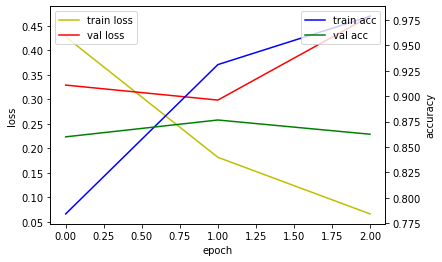

In [ ]:
acc_loss_plot(hist)

In [ ]:
y_test = test_data['sentiment'] 
y_test[y_test=='positive'] = 1
y_test[y_test=='negative'] = 0
y_test_one = to_categorical(y_test)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
y_test_one

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
score = model.evaluate(X_test,y_test_one)

469/469 [==============================] - 2s 3ms/step - loss: 0.4611 - accuracy: 0.8616


In [ ]:
score[1]

0.8615999817848206

#### -RMSprop

In [ ]:
input = Input(shape=(maxlen, )) 
layer = Embedding(max_features, 300, weights=[embedding_matrix], input_length=maxlen, trainable=True)(input)
layer = Conv1D(128, kernel_size = 3, activation='relu')(layer)   
layer = Conv1D(64, kernel_size = 3, activation='relu')(layer)  
avg_pool = GlobalAveragePooling1D()(layer)
max_pool = GlobalMaxPooling1D()(layer)
layer = concatenate([avg_pool, max_pool])
layer = Dense(50,activation='relu')(layer)
layer = Flatten()(layer)
layer= Dense(2, activation="sigmoid")(layer)


model = Model(inputs = input, outputs = layer)  
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 90)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 90, 300)      27000000    ['input_2[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 88, 128)      115328      ['embedding_1[0][0]']            
                                                                                                  
 conv1d_3 (Conv1D)              (None, 86, 64)       24640       ['conv1d_2[0][0]']               
                                                                                            

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.005),metrics=['accuracy'])

In [ ]:
file_path = '{epoch:02d}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(file_path,monitor='val_loss',verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [ ]:
y_train_one = to_categorical(y_train)
y_val_one = to_categorical(y_val)

In [ ]:
hist = model.fit(x_train, y_train_one, epochs=5,batch_size=256, validation_data=(x_val,y_val_one), callbacks= [checkpoint,early_stop])

Epoch 1/5
124/124 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.7584
Epoch 1: val_loss improved from inf to 0.37426, saving model to 01-0.37426.h5
124/124 [==============================] - 4s 23ms/step - loss: 0.4912 - accuracy: 0.7584 - val_loss: 0.3743 - val_accuracy: 0.8366
Epoch 2/5
123/124 [============================>.] - ETA: 0s - loss: 0.2816 - accuracy: 0.8811
Epoch 2: val_loss did not improve from 0.37426
124/124 [==============================] - 2s 16ms/step - loss: 0.2816 - accuracy: 0.8810 - val_loss: 0.4856 - val_accuracy: 0.8120


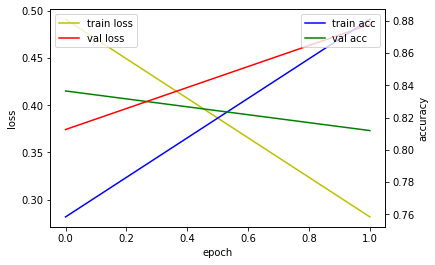

In [ ]:
acc_loss_plot(hist)

In [ ]:
y_test = test_data['sentiment'] 
y_test[y_test=='positive'] = 1
y_test[y_test=='negative'] = 0
y_test_one = to_categorical(y_test)

In [ ]:
score = model.evaluate(X_test,y_test_one)

469/469 [==============================] - 1s 3ms/step - loss: 0.4402 - accuracy: 0.8203


In [ ]:
score[1]

0.8202666640281677